In [1]:
from __future__ import print_function

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time

Using MXNet backend.


In [2]:
def PreprocessDataset():
    from sklearn import preprocessing
    ## Load dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    ## Transform labels to one-hot
    ## i.e., from '7' to [0,0,0,0,0,0,0,1,0,0]
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    
    ## Process features. Set numeric type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    ## Reshape from a matrix of 28 x 28 pixels to 1-D vector of 784 dimensions
    x_train = np.reshape(x_train, (60000, 784))
    x_test = np.reshape(x_test, (10000, 784))
    
    # proceed w/ standardizing datasets by z-scoring (de-mean, uni-variance).
    # x_train = preprocessing.scale(x_train)
    # x_test = preprocessing.scale(x_test)
 
    ## min-max normalization 
    x_train /= 255
    x_test /= 255

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = PreprocessDataset()

In [3]:
## Show part of training data: features and labels
## Each row is a sample, and each column represents a feature.
print("{:^43}".format("x"), "|", "{:^4}".format("y"))
print("="*50)
for sample_id in range(10):
    print("{:.2f} {:.2f} ... {:.2f} {:.2f} {:.2f} ...  {:.2f} {:.2f}".format(
            x_train[sample_id][0], x_train[sample_id][1],
            x_train[sample_id][156], x_train[sample_id][157], x_train[sample_id][158],
            x_train[sample_id][-2], x_train[sample_id][-1]), "| ",
           "{:.0f}".format(y_train[sample_id][0]))

                     x                      |  y  
0.00 0.00 ... 0.49 0.53 0.69 ...  0.00 0.00 |  0
0.00 0.00 ... 0.99 0.99 0.99 ...  0.00 0.00 |  1
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.49 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.10 0.39 0.48 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.99 0.99 0.99 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0
0.00 0.00 ... 0.00 0.00 0.00 ...  0.00 0.00 |  0


In [4]:
def DefineModel():

    #Network Structure uses 2 layers of a pyramid-shaped (shrink width) network.
    first_layer_width = 128
    second_layer_width = 64    
    
    # use relu as activation function
    activation_func = 'relu' 

    # Loss Function: since data is categorical, we use cross entropy as loss  
    loss_function = 'categorical_crossentropy'
    
    # set dropout for overfitting   
    dropout_rate = 0.0
    
    # set Regularization for overfitting, L1,L2 or none
    # weight_regularizer = l1(0.01)
    # weight_regularizer = l2(0.01)
    # weight_regularizer = None
    weight_regularizer = None

    #learning rate usually between 0.05~0.1
    learning_rate = 0.1
    
    ## Initialize model.
    model = Sequential()

    ## First hidden layer with 'first_layer_width' neurons. 
    ## Also need to specify input dimension.
    ## 'Dense' means fully-connected.
    model.add(Dense(first_layer_width, input_dim=784, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    ## Second hidden layer.
    if second_layer_width > 0:
        model.add(Dense(second_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))         
    
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(10))
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    #optimizer:SGD
    ## You can also use other methods, e.g., opt = RMSprop()
    opt = SGD(lr=learning_rate, clipnorm=5.)
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

    return model

In [5]:
def TrainModel(data=None, epochs=20):
    #uses mini-batch of size 128,256 or 512
    batch=128
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print("Must provide data.")
        return
    x_train, x_test, y_train, y_test = data
    print('Start training.')
    ## Use the first 55,000 (out of 60,000) samples to train, last 5,500 samples to validate.
    history = model.fit(x_train[:55000], y_train[:55000], nb_epoch=epochs, batch_size=batch,
              validation_data=(x_train[55000:], y_train[55000:]))
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

In [6]:
trained_model, training_history = TrainModel(data=[x_train, x_test, y_train, y_test])

Start training.
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
 2304/55000 [>.............................] - ETA: 4s - loss: 2.0030 - acc: 0.3615

/usr/lib/python2.7/dist-packages/mxnet-0.11.0-py2.7.egg/mxnet/module/bucketing_module.py:385: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0078125). Is this intended?
  force_init=force_init)


55000/55000 [==============================] - 2s - loss: 0.4719 - acc: 0.8639 - val_loss: 0.1992 - val_acc: 0.9462
Epoch 2/20
55000/55000 [==============================] - 2s - loss: 0.2191 - acc: 0.9355 - val_loss: 0.1853 - val_acc: 0.9452
Epoch 3/20
55000/55000 [==============================] - 2s - loss: 0.1649 - acc: 0.9515 - val_loss: 0.1227 - val_acc: 0.9638
Epoch 4/20
55000/55000 [==============================] - 2s - loss: 0.1343 - acc: 0.9604 - val_loss: 0.1061 - val_acc: 0.9704
Epoch 5/20
55000/55000 [==============================] - 2s - loss: 0.1112 - acc: 0.9666 - val_loss: 0.1083 - val_acc: 0.9686
Epoch 6/20
55000/55000 [==============================] - 2s - loss: 0.0957 - acc: 0.9721 - val_loss: 0.0996 - val_acc: 0.9728
Epoch 7/20
55000/55000 [==============================] - 2s - loss: 0.0830 - acc: 0.9757 - val_loss: 0.1154 - val_acc: 0.9652
Epoch 8/20
55000/55000 [==============================] - 2s - loss: 0.0741 - acc: 0.9782 - val_loss: 0.0875 - val_acc: 0.

In [7]:
# define plotting
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ## Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc) 

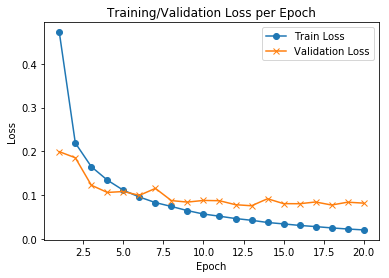

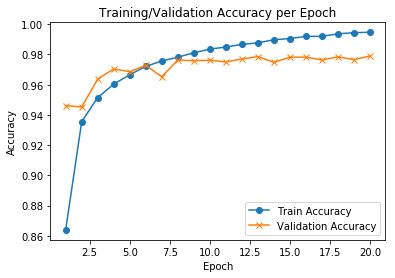

In [8]:
# observe training process
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

In [9]:
# observe regularization effects
def drawWeightHistogram(x):
    ## the histogram of the data
    fig = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

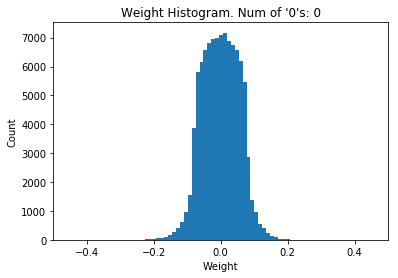

In [10]:
w1 = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(w1)

In [11]:
# define testing procedure
def TestModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

In [12]:
# test trained model
test_score = TestModel(model=trained_model, data=[x_test, y_test])
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

 9728/10000 [============================>.] - ETA: 0sTest loss 0.0777, accuracy 97.77%


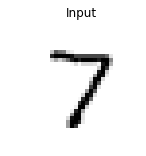

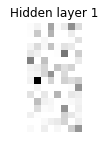

Final prediction: 7


In [13]:
def ShowInputImage(data):
    """Visualize input image."""
    plot = plt.figure()
    plot.set_size_inches(2,2)
    plt.imshow(np.reshape(-data, (28,28)), cmap='Greys_r')
    plt.title("Input")
    plt.axis('off')
    plt.show()
    
def ShowHiddenLayerOutput(input_data, target_layer_num):
    """Visualize output from the target hidden layer."""
    from keras import backend as K
    ## Backend converter: to TensorFlow
    target_layer = K.function(trained_model.inputs, [trained_model.layers[target_layer_num].output])
    ## Extract output from the target hidden layer.
    target_layer_out = target_layer([input_data])
    plot = plt.figure()
    plot.set_size_inches(2,2)
    plt.imshow(np.reshape(-target_layer_out[0][0], (16,-1)), cmap='Greys_r')
    plt.title("Hidden layer " + str(target_layer_num))
    plt.axis('off')
    plt.show()

def ShowFinalOutput(input_data):
    """Calculate final prediction."""
    from keras import backend as K
    ## Backend converter: to TensorFlow
    ## Calculate final prediction.
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print("Final prediction: " + str(np.argmax(last_layer_out[0][0])) )

ShowInputImage(x_test[0])
ShowHiddenLayerOutput(x_test, 1)
ShowFinalOutput(x_test)